# LSTM

## Imports / Settings

In [1]:
%pip install dotenv
%pip install spacy
!python -m spacy download en_core_web_sm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
2025-06-14 15:12:34.817553: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-14 15:12:34.817784: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-14 15:12:34.943692: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-14 15:12:35.038779: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA

In [2]:
%load_ext autoreload
%autoreload 2

In [26]:
import pandas as pd
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
import os

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import pandas as pd
from tqdm import tqdm
import re

import spacy
import time

from utils.evaluationUtility import analyze_all_results

In [4]:
IS_PAPERSPACE = os.getcwd().startswith('/notebooks')
dir_env = os.path.join(os.getcwd(), '.env') if IS_PAPERSPACE else os.path.join(os.getcwd(), '..', '.env')
_ = load_dotenv(dotenv_path=dir_env)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f'Using GPU: {torch.cuda.get_device_name(0)}')

Using GPU: Quadro P5000


## Data

In [6]:
df_traindata = pd.read_csv("data/train.csv") if IS_PAPERSPACE else pd.read_csv("../data/train.csv")
train_texts, validation_texts, train_labels, validation_labels = train_test_split(
    df_traindata['text'].tolist(), 
    df_traindata['sentiment'].tolist(), 
    test_size=0.2, 
    random_state=42
)

df_testdata = pd.read_csv("data/test.csv") if IS_PAPERSPACE else pd.read_csv("../data/test.csv")
test_texts = df_testdata['text'].tolist()
test_labels = df_testdata['sentiment'].tolist()

In [7]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels=None, vocabulary=None):
        self.texts = texts
        self.labels = labels
        self.vocabulary = vocabulary

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return torch.tensor(self.vocabulary.numericalize(self.texts[idx])), torch.tensor(self.labels[idx])
    
def pad_collate(batch):
    texts, labels = zip(*batch)
    lengths = torch.tensor([len(x) for x in texts])
    padded = nn.utils.rnn.pad_sequence(texts, batch_first=True, padding_value=0)
    return padded, lengths, torch.tensor(labels).float()

In [8]:
class TokenizedSentimentDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = [torch.tensor(label, dtype=torch.float) for label in labels]

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]

## Tokenizer

In [9]:
def simple_tokenizer(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text.lower())
    return text.split()

class Vocabulary:
    def __init__(self, texts, tokenizer, min_freq=2):
        self.tokenizer = tokenizer
        counter = Counter()
        for text in texts:
            counter.update(self.tokenizer(text))
        
        self.stoi = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in counter.items():
            if freq >= min_freq:
                self.stoi[word] = len(self.stoi)
        self.itos = {i: s for s, i in self.stoi.items()}

    def numericalize(self, text):
        return [self.stoi.get(word, self.stoi["<UNK>"]) for word in self.tokenizer(text)]
    
nlp = spacy.load("en_core_web_sm")

def spacy_tokenizer(text):
    return [token.text for token in nlp(text) if not token.is_punct and not token.is_space]

class TokenizedVocabulary:
    def __init__(self, tokenized_texts, min_freq=2):
        counter = Counter()
        for tokens in tokenized_texts:
            counter.update(tokens)

        self.stoi = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in counter.items():
            if freq >= min_freq:
                self.stoi[word] = len(self.stoi)
        self.itos = {i: s for s, i in self.stoi.items()}

    def numericalize(self, tokens):
        return [self.stoi.get(token, self.stoi["<UNK>"]) for token in tokens]

## Embedding

In [10]:
def load_glove_embeddings(vocab, glove_path="glove.6B.100d.txt", dim=100):
    embeddings_index = {}
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = torch.tensor([float(val) for val in values[1:]], dtype=torch.float)
            embeddings_index[word] = vector

    embedding_matrix = torch.randn(len(vocab.stoi), dim)  # Random init
    for word, idx in vocab.stoi.items():
        if word in embeddings_index:
            embedding_matrix[idx] = embeddings_index[word]

    return embedding_matrix

## Classifier

In [11]:
class LSTMSentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers,
                            bidirectional=bidirectional, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, lengths):
        embedded = self.dropout(self.embedding(x))
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hidden, _) = self.lstm(packed)
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2], hidden[-1]), dim=1))
        else:
            hidden = self.dropout(hidden[-1])
        return self.fc(hidden).squeeze()

## Metrics

In [12]:
def calculate_metrics(model, data_loader, device='cuda'):
    
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, lengths, y in data_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            predictions = model(x, lengths)
            
            preds = torch.round(torch.sigmoid(predictions))
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="weighted", zero_division=0
    )
    
    return precision, recall, f1

def measure_inference_time(model, data_loader, device='cuda'):
    model.eval()
    total_time = 0
    n_samples = 0
    with torch.no_grad():
        for inputs, lengths, _ in data_loader:
            inputs = inputs.to(device)
            n_samples += inputs.size(0)
            start = time.time()
            _ = model(inputs, lengths)
            end = time.time()
            total_time += (end - start)
    return total_time

def evaluate_model(model, model_name, classifier_name, vectorizer_name, training_duration, val_data_loader, test_data_loader, device='cuda'):
    val_precision, val_recall, val_f1 = calculate_metrics(model, val_data_loader, device)
    test_precision, test_recall, test_f1 = calculate_metrics(model, test_data_loader, device)
    
    inference_time = measure_inference_time(model, test_data_loader, device)
    
    result = {
        'classifier': classifier_name,
        'vectorizer': vectorizer_name,
        'val_accuracy': None,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'val_f1': val_f1,
        'test_accuracy': None,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'training_duration': training_duration,
        'inference_time': inference_time,
    }

    results_name = f"executions/{model_name}/{classifier_name}_{vectorizer_name}"
    result_df = pd.DataFrame([result])
    result_df.to_csv(f"{results_name}.csv", index=False)

## Training

In [13]:
def train_model(model, train_loader, val_loader, epochs=5):
    
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.BCEWithLogitsLoss()
    model.to(device)
    criterion.to(device)

    start_time = time.time()

    for epoch in range(epochs):
        # ====== Training =====
        model.train()
        train_loss, _ = 0, 0
        for x, lengths, y in tqdm(train_loader):
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            predictions = model(x, lengths)
            loss = criterion(predictions, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # ====== Validation =====
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for x, lengths, y in val_loader:
                x, lengths, y = x.to(device), lengths.to(device), y.to(device)
                predictions = model(x, lengths)
                loss = criterion(predictions, y)
                val_loss += loss.item()

                preds = torch.round(torch.sigmoid(predictions))
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y.cpu().numpy())

        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, all_preds, average="weighted", zero_division=0
        )

        print(f"Epoch {epoch+1} | Train Loss: {train_loss / len(train_loader):.4f} | "
              f"Val Loss: {val_loss / len(val_loader):.4f} | "
              f"P: {precision:.4f} R: {recall:.4f} F1: {f1:.4f}")

    end_time = time.time()
    return end_time - start_time

### LSTM with simple tokenizer

In [14]:
vocabulary = Vocabulary(texts=train_texts, tokenizer=simple_tokenizer)

train_dataset = SentimentDataset(train_texts, train_labels, vocabulary)
val_dataset = SentimentDataset(validation_texts, validation_labels, vocabulary)
test_dataset = SentimentDataset(test_texts, test_labels, vocabulary)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=pad_collate)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=pad_collate)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=pad_collate)

#### 5 epochs, hidden dimension 128

In [15]:
model = LSTMSentimentClassifier(
    vocab_size=len(vocabulary.stoi),
    embed_dim=100,
    hidden_dim=128,
    output_dim=1,
    num_layers=2,
    bidirectional=True,
    dropout=0.5
)

training_time = train_model(model=model, train_loader=train_loader, val_loader=val_loader, epochs=5)

evaluate_model(
    model=model, 
    model_name="lstm", 
    classifier_name="LSTM", 
    vectorizer_name="SimpleTokenizer-5e-128h", 
    training_duration=training_time, 
    val_data_loader=val_loader, 
    test_data_loader=test_loader)

100%|██████████| 4500/4500 [00:57<00:00, 77.71it/s]


Epoch 1 | Train Loss: 0.5512 | Val Loss: 0.4673 | P: 0.7746 R: 0.7746 F1: 0.7746


100%|██████████| 4500/4500 [01:03<00:00, 70.77it/s]


Epoch 2 | Train Loss: 0.4763 | Val Loss: 0.4391 | P: 0.7904 R: 0.7913 F1: 0.7906


100%|██████████| 4500/4500 [00:59<00:00, 75.03it/s]


Epoch 3 | Train Loss: 0.4468 | Val Loss: 0.4309 | P: 0.7990 R: 0.7998 F1: 0.7991


100%|██████████| 4500/4500 [01:00<00:00, 74.65it/s]


Epoch 4 | Train Loss: 0.4263 | Val Loss: 0.4206 | P: 0.8033 R: 0.8036 F1: 0.8034


100%|██████████| 4500/4500 [00:59<00:00, 75.07it/s]


Epoch 5 | Train Loss: 0.4087 | Val Loss: 0.4234 | P: 0.8062 R: 0.8057 F1: 0.8059


#### 10 epochs, hidden dimension 128

In [16]:
model = LSTMSentimentClassifier(
    vocab_size=len(vocabulary.stoi),
    embed_dim=100,
    hidden_dim=128,
    output_dim=1,
    num_layers=2,
    bidirectional=True,
    dropout=0.5
)

training_time = train_model(model=model, train_loader=train_loader, val_loader=val_loader, epochs=10)

evaluate_model(
    model=model, 
    model_name="lstm", 
    classifier_name="LSTM", 
    vectorizer_name="SimpleTokenizer-10e-128h",
    training_duration=training_time, 
    val_data_loader=val_loader, 
    test_data_loader=test_loader)

100%|██████████| 4500/4500 [01:02<00:00, 71.60it/s]


Epoch 1 | Train Loss: 0.5499 | Val Loss: 0.4661 | P: 0.7766 R: 0.7734 F1: 0.7743


100%|██████████| 4500/4500 [01:04<00:00, 69.76it/s]


Epoch 2 | Train Loss: 0.4771 | Val Loss: 0.4435 | P: 0.7923 R: 0.7898 F1: 0.7906


100%|██████████| 4500/4500 [01:00<00:00, 74.26it/s]


Epoch 3 | Train Loss: 0.4464 | Val Loss: 0.4304 | P: 0.7997 R: 0.7990 F1: 0.7993


100%|██████████| 4500/4500 [01:02<00:00, 72.20it/s]


Epoch 4 | Train Loss: 0.4257 | Val Loss: 0.4307 | P: 0.8038 R: 0.8033 F1: 0.8035


100%|██████████| 4500/4500 [00:59<00:00, 75.94it/s]


Epoch 5 | Train Loss: 0.4096 | Val Loss: 0.4282 | P: 0.8066 R: 0.8044 F1: 0.8051


100%|██████████| 4500/4500 [01:02<00:00, 72.58it/s]


Epoch 6 | Train Loss: 0.3951 | Val Loss: 0.4197 | P: 0.8078 R: 0.8061 F1: 0.8066


100%|██████████| 4500/4500 [01:01<00:00, 73.30it/s]


Epoch 7 | Train Loss: 0.3831 | Val Loss: 0.4294 | P: 0.8077 R: 0.8046 F1: 0.8053


100%|██████████| 4500/4500 [01:01<00:00, 72.76it/s]


Epoch 8 | Train Loss: 0.3707 | Val Loss: 0.4328 | P: 0.8090 R: 0.8058 F1: 0.8066


100%|██████████| 4500/4500 [01:03<00:00, 70.91it/s]


Epoch 9 | Train Loss: 0.3644 | Val Loss: 0.4368 | P: 0.8101 R: 0.8076 F1: 0.8082


100%|██████████| 4500/4500 [00:59<00:00, 75.96it/s]


Epoch 10 | Train Loss: 0.3557 | Val Loss: 0.4286 | P: 0.8104 R: 0.8102 F1: 0.8103


#### 5 epochs, hidden dimension 256

In [17]:
model = LSTMSentimentClassifier(
    vocab_size=len(vocabulary.stoi),
    embed_dim=100,
    hidden_dim=256,
    output_dim=1,
    num_layers=2,
    bidirectional=True,
    dropout=0.5
)

training_time = train_model(model=model, train_loader=train_loader, val_loader=val_loader, epochs=5)

evaluate_model(
    model=model, 
    model_name="lstm", 
    classifier_name="LSTM", 
    vectorizer_name="SimpleTokenizer-5e-256h",
    training_duration=training_time, 
    val_data_loader=val_loader, 
    test_data_loader=test_loader)

100%|██████████| 4500/4500 [01:04<00:00, 70.07it/s]


Epoch 1 | Train Loss: 0.5481 | Val Loss: 0.4664 | P: 0.7756 R: 0.7764 F1: 0.7758


100%|██████████| 4500/4500 [01:04<00:00, 69.41it/s]


Epoch 2 | Train Loss: 0.4735 | Val Loss: 0.4412 | P: 0.7930 R: 0.7927 F1: 0.7929


100%|██████████| 4500/4500 [01:04<00:00, 69.94it/s]


Epoch 3 | Train Loss: 0.4414 | Val Loss: 0.4295 | P: 0.8005 R: 0.8001 F1: 0.8002


100%|██████████| 4500/4500 [01:04<00:00, 69.56it/s]


Epoch 4 | Train Loss: 0.4199 | Val Loss: 0.4346 | P: 0.8060 R: 0.8026 F1: 0.8034


100%|██████████| 4500/4500 [01:06<00:00, 67.68it/s]


Epoch 5 | Train Loss: 0.4028 | Val Loss: 0.4164 | P: 0.8088 R: 0.8093 F1: 0.8090


### LSTM with spaCy tokenizer and GloVe embedding

In [18]:
tokenized_train_texts = [
    [token.lemma_.lower() for token in doc if token.is_alpha]
    for doc in nlp.pipe(train_texts, batch_size=64)
]

tokenized_val_texts = [
    [token.lemma_.lower() for token in doc if token.is_alpha]
    for doc in nlp.pipe(validation_texts, batch_size=64)
]

tokenized_test_texts = [
    [token.lemma_.lower() for token in doc if token.is_alpha]
    for doc in nlp.pipe(test_texts, batch_size=64)
]

In [19]:
vocabulary = TokenizedVocabulary(tokenized_train_texts, min_freq=2)

In [20]:
embedding_matrix = load_glove_embeddings(vocabulary)

In [21]:
filtered = [
    (torch.tensor(vocabulary.numericalize(tokens), dtype=torch.long), label)
    for tokens, label in zip(tokenized_train_texts, train_labels)
    if len(tokens) > 0
]
train_inputs, train_labels = zip(*filtered)

filtered = [
    (torch.tensor(vocabulary.numericalize(tokens), dtype=torch.long), label)
    for tokens, label in zip(tokenized_val_texts, validation_labels)
    if len(tokens) > 0
]
val_inputs, validation_labels = zip(*filtered)

filtered = [
    (torch.tensor(vocabulary.numericalize(tokens), dtype=torch.long), label)
    for tokens, label in zip(tokenized_test_texts, test_labels)
    if len(tokens) > 0
]
test_inputs, test_labels = zip(*filtered)

In [22]:
train_dataset = TokenizedSentimentDataset(train_inputs, train_labels)
val_dataset = TokenizedSentimentDataset(val_inputs, validation_labels)
test_dataset = TokenizedSentimentDataset(test_inputs, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=pad_collate, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=pad_collate, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=pad_collate, num_workers=8, pin_memory=True)

#### 5 epochs, hidden dimension 128

In [23]:
model = LSTMSentimentClassifier(
    vocab_size=len(vocabulary.stoi),
    embed_dim=100,
    hidden_dim=128,
    output_dim=1,
    num_layers=2,
    bidirectional=True,
    dropout=0.5
)

model.embedding.weight.data.copy_(embedding_matrix)
training_duration = train_model(model=model, train_loader=train_loader, val_loader=val_loader, epochs=5)

evaluate_model(
    model=model, 
    model_name="lstm", 
    classifier_name="LSTM", 
    vectorizer_name="SpacyTokenizer-5e-128h", 
    training_duration=training_duration, 
    val_data_loader=val_loader, 
    test_data_loader=test_loader)

100%|██████████| 4489/4489 [00:56<00:00, 79.83it/s]


Epoch 1 | Train Loss: 0.5051 | Val Loss: 0.4475 | P: 0.7846 R: 0.7857 F1: 0.7840


100%|██████████| 4489/4489 [00:59<00:00, 76.08it/s]


Epoch 2 | Train Loss: 0.4483 | Val Loss: 0.4307 | P: 0.7944 R: 0.7953 F1: 0.7942


100%|██████████| 4489/4489 [01:00<00:00, 74.27it/s]


Epoch 3 | Train Loss: 0.4256 | Val Loss: 0.4290 | P: 0.8002 R: 0.8011 F1: 0.8001


100%|██████████| 4489/4489 [00:59<00:00, 75.63it/s]


Epoch 4 | Train Loss: 0.4072 | Val Loss: 0.4200 | P: 0.8038 R: 0.8046 F1: 0.8036


100%|██████████| 4489/4489 [00:59<00:00, 76.03it/s]


Epoch 5 | Train Loss: 0.3938 | Val Loss: 0.4269 | P: 0.8036 R: 0.8021 F1: 0.8026


#### 10 epochs, hidden dimension 128

In [24]:
model = LSTMSentimentClassifier(
    vocab_size=len(vocabulary.stoi),
    embed_dim=100,
    hidden_dim=128,
    output_dim=1,
    num_layers=2,
    bidirectional=True,
    dropout=0.5
)

model.embedding.weight.data.copy_(embedding_matrix)
training_duration = train_model(model=model, train_loader=train_loader, val_loader=val_loader, epochs=10)

evaluate_model(
    model=model, 
    model_name="lstm", 
    classifier_name="LSTM", 
    vectorizer_name="SpacyTokenizer-10e-128h", 
    training_duration=training_duration, 
    val_data_loader=val_loader, 
    test_data_loader=test_loader)

100%|██████████| 4489/4489 [00:59<00:00, 75.83it/s]


Epoch 1 | Train Loss: 0.5055 | Val Loss: 0.4470 | P: 0.7855 R: 0.7849 F1: 0.7813


100%|██████████| 4489/4489 [00:58<00:00, 77.36it/s]


Epoch 2 | Train Loss: 0.4489 | Val Loss: 0.4373 | P: 0.7926 R: 0.7913 F1: 0.7876


100%|██████████| 4489/4489 [00:54<00:00, 82.11it/s]


Epoch 3 | Train Loss: 0.4255 | Val Loss: 0.4260 | P: 0.8010 R: 0.8019 F1: 0.8008


100%|██████████| 4489/4489 [00:57<00:00, 78.50it/s]


Epoch 4 | Train Loss: 0.4087 | Val Loss: 0.4214 | P: 0.8026 R: 0.8033 F1: 0.8027


100%|██████████| 4489/4489 [00:56<00:00, 79.63it/s]


Epoch 5 | Train Loss: 0.3940 | Val Loss: 0.4324 | P: 0.8020 R: 0.8026 F1: 0.8022


100%|██████████| 4489/4489 [00:57<00:00, 78.34it/s]


Epoch 6 | Train Loss: 0.3812 | Val Loss: 0.4220 | P: 0.8018 R: 0.8023 F1: 0.8020


100%|██████████| 4489/4489 [00:57<00:00, 77.46it/s]


Epoch 7 | Train Loss: 0.3690 | Val Loss: 0.4352 | P: 0.8023 R: 0.8030 F1: 0.8025


100%|██████████| 4489/4489 [00:56<00:00, 79.56it/s]


Epoch 8 | Train Loss: 0.3609 | Val Loss: 0.4342 | P: 0.8031 R: 0.8039 F1: 0.8032


100%|██████████| 4489/4489 [00:59<00:00, 75.31it/s]


Epoch 9 | Train Loss: 0.3510 | Val Loss: 0.4456 | P: 0.8005 R: 0.8014 F1: 0.8006


100%|██████████| 4489/4489 [00:58<00:00, 76.64it/s]


Epoch 10 | Train Loss: 0.3431 | Val Loss: 0.4491 | P: 0.8005 R: 0.8011 F1: 0.8006


#### 5 epochs, hidden dimension 256

In [25]:
model = LSTMSentimentClassifier(
    vocab_size=len(vocabulary.stoi),
    embed_dim=100,
    hidden_dim=256,
    output_dim=1,
    num_layers=2,
    bidirectional=True,
    dropout=0.5
)

model.embedding.weight.data.copy_(embedding_matrix)
training_duration = train_model(model=model, train_loader=train_loader, val_loader=val_loader, epochs=5)

evaluate_model(
    model=model, 
    model_name="lstm", 
    classifier_name="LSTM", 
    vectorizer_name="SpacyTokenizer-5e-256h", 
    training_duration=training_duration, 
    val_data_loader=val_loader, 
    test_data_loader=test_loader)

100%|██████████| 4489/4489 [00:58<00:00, 76.36it/s]


Epoch 1 | Train Loss: 0.5060 | Val Loss: 0.4436 | P: 0.7875 R: 0.7884 F1: 0.7877


100%|██████████| 4489/4489 [00:56<00:00, 78.96it/s]


Epoch 2 | Train Loss: 0.4469 | Val Loss: 0.4298 | P: 0.7985 R: 0.7991 F1: 0.7987


100%|██████████| 4489/4489 [00:59<00:00, 75.87it/s]


Epoch 3 | Train Loss: 0.4238 | Val Loss: 0.4232 | P: 0.8008 R: 0.8009 F1: 0.8008


100%|██████████| 4489/4489 [01:00<00:00, 73.99it/s]


Epoch 4 | Train Loss: 0.4064 | Val Loss: 0.4218 | P: 0.8033 R: 0.8037 F1: 0.8034


100%|██████████| 4489/4489 [00:58<00:00, 76.32it/s]


Epoch 5 | Train Loss: 0.3904 | Val Loss: 0.4248 | P: 0.8052 R: 0.8060 F1: 0.8051


Failed to load confusion matrix for LSTM_SimpleTokenizer-10e-128h: [Errno 2] No such file or directory: 'executions/lstm/LSTM_SimpleTokenizer-10e-128h_val_confusion.json'
Failed to load confusion matrix for LSTM_SimpleTokenizer-5e-128h: [Errno 2] No such file or directory: 'executions/lstm/LSTM_SimpleTokenizer-5e-128h_val_confusion.json'
Failed to load confusion matrix for LSTM_SimpleTokenizer-5e-256h: [Errno 2] No such file or directory: 'executions/lstm/LSTM_SimpleTokenizer-5e-256h_val_confusion.json'
Failed to load confusion matrix for LSTM_SpacyTokenizer-10e-128h: [Errno 2] No such file or directory: 'executions/lstm/LSTM_SpacyTokenizer-10e-128h_val_confusion.json'
Failed to load confusion matrix for LSTM_SpacyTokenizer-5e-256h: [Errno 2] No such file or directory: 'executions/lstm/LSTM_SpacyTokenizer-5e-256h_val_confusion.json'
Failed to load confusion matrix for LSTM_SpacyTokenizer-5e-128h: [Errno 2] No such file or directory: 'executions/lstm/LSTM_SpacyTokenizer-5e-128h_val_conf

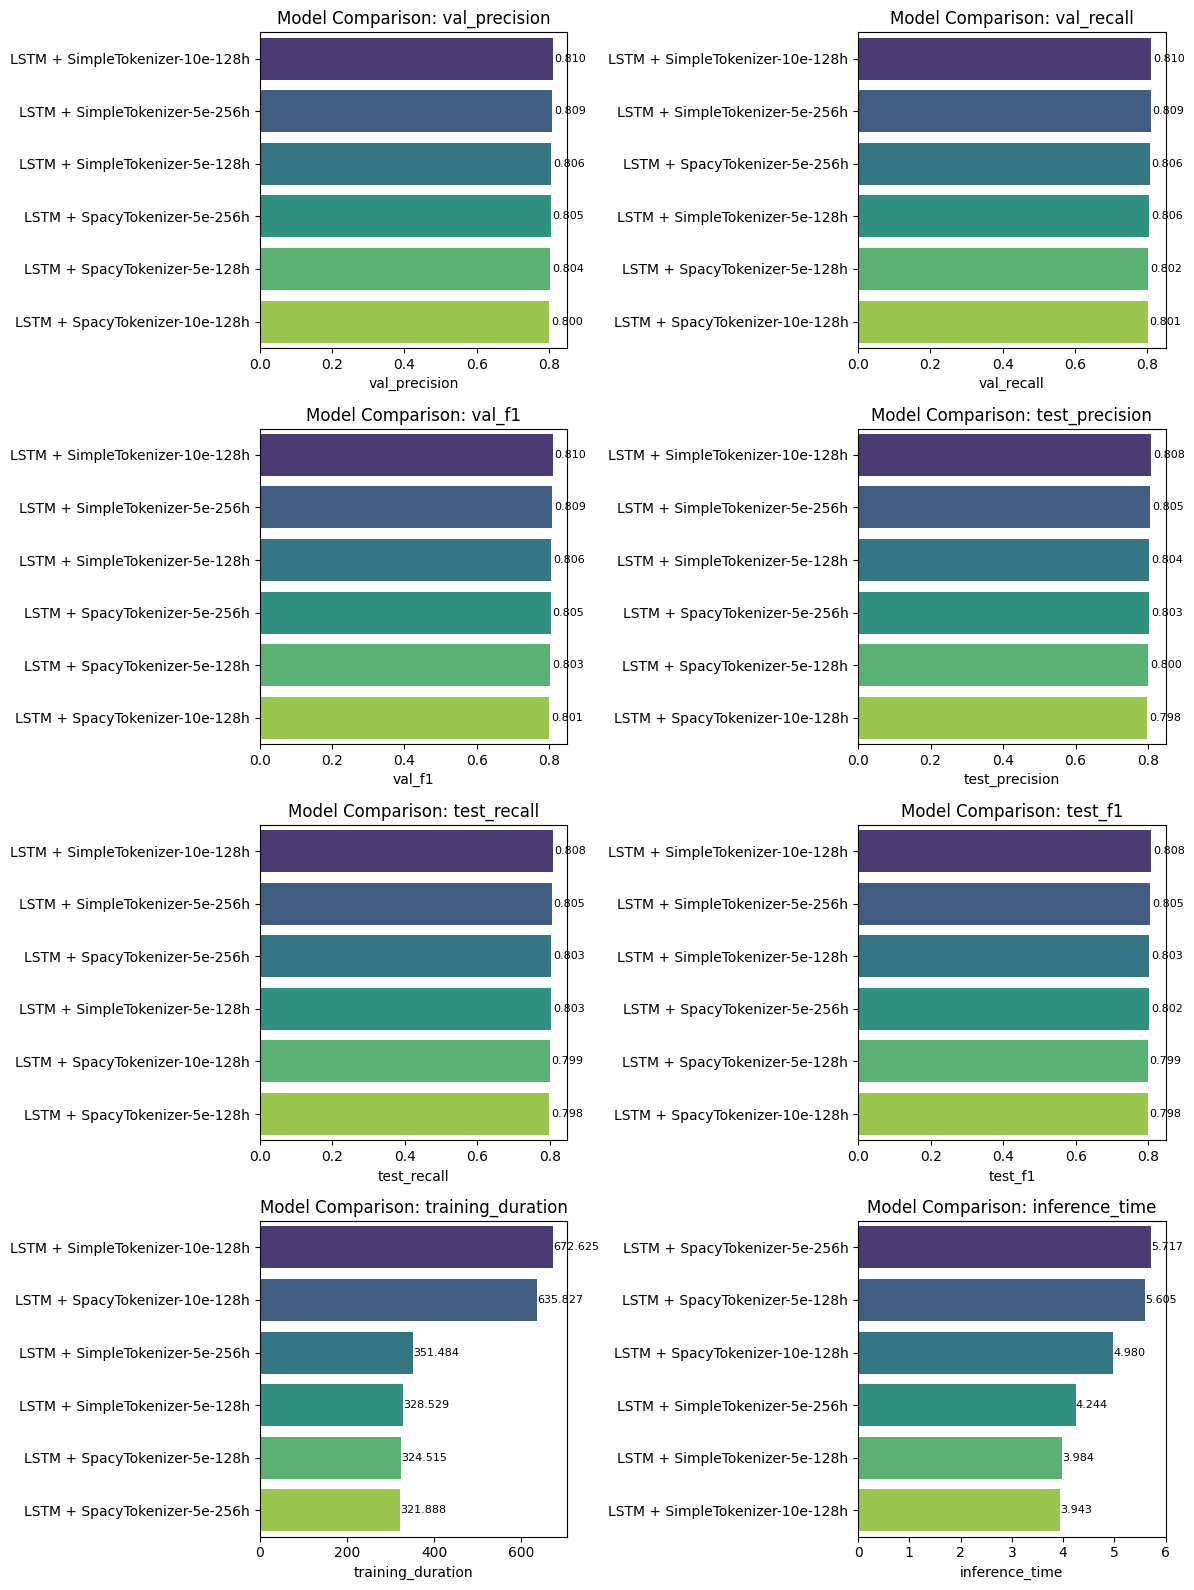

,classifier,vectorizer,val_accuracy,val_precision,val_recall,val_f1,test_accuracy,test_precision,test_recall,test_f1,training_duration,inference_time,Classifier,Vectorizer,Model
0,LSTM,SimpleTokenizer-10e-128h,NaN,0.810418,0.810245,0.810326,NaN,0.808231,0.807951,0.808077,672.625380,3.942535,LSTM,SimpleTokenizer-10e-128h,LSTM + SimpleTokenizer-10e-128h
1,LSTM,SimpleTokenizer-5e-128h,NaN,0.806213,0.805689,0.805909,NaN,0.803698,0.803107,0.803349,328.529348,3.983692,LSTM,SimpleTokenizer-5e-128h,LSTM + SimpleTokenizer-5e-128h
2,LSTM,SimpleTokenizer-5e-256h,NaN,0.808812,0.809328,0.808983,NaN,0.805147,0.805485,0.805285,351.484353,4.243675,LSTM,SimpleTokenizer-5e-256h,LSTM + SimpleTokenizer-5e-256h
3,LSTM,SpacyTokenizer-10e-128h,NaN,0.800458,0.801081,0.800648,NaN,0.798259,0.798886,0.798444,635.826721,4.979593,LSTM,SpacyTokenizer-10e-128h,LSTM + SpacyTokenizer-10e-128h
4,LSTM,SpacyTokenizer-5e-256h,NaN,0.805207,0.806038,0.805076,NaN,0.802523,0.803341,0.802485,321.887582,5.717347,LSTM,SpacyTokenizer-5e-256h,LSTM + SpacyTokenizer-5e-256h
5,LSTM,SpacyTokenizer-5e-128h,NaN,0.803602,0.802083,0.802593,NaN,0.799952,0.798396,0.798913,324.515423,5.605409,LSTM,SpacyTokenizer-5e-128h,LSTM + SpacyTokenizer-5e-128h


In [29]:
analyze_all_results(results_dir="executions/lstm")